In [0]:
"""
Distributed Proximal Policy Optimization (Distributed PPO or DPPO) continuous 
version implementation with distributed Tensorflow and Python’s multiprocessing 
package. This implementation uses normalized running rewards with GAE. The code 
is tested with Gym’s continuous action space environment, Pendulum-v0 on Colab.
"""

from __future__ import absolute_import, division, print_function, unicode_literals
#!pip install -q tf-nightly

In [0]:
import tensorflow as tf
tf.reset_default_graph()

import numpy as np
import matplotlib.pyplot as plt
import gym
import time
from multiprocessing import Process

In [0]:
# The following class is adapted from OpenAI's baseline:
# https://github.com/openai/baselines/blob/master/baselines/common/running_mean_std.py
# https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
# This class is used for the normalization of rewards in this program before GAE computation.
class RunningStats(object):
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.std = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        new_mean = self.mean + delta * batch_count / (self.count + batch_count)
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        new_var = M2 / (self.count + batch_count)

        self.mean = new_mean
        self.var = new_var
        self.std = np.maximum(np.sqrt(self.var), 1e-6)
        self.count = batch_count + self.count

In [0]:
class PPO(object):    
    def __init__(self, scope, sess, env, global_PPO=None):    
        self.sess = sess
        self.env = env
        #OPT_A = tf.train.AdamOptimizer(A_LR, beta1=0.99, beta2=0.999, name='OPT_A')
        #OPT_C = tf.train.AdamOptimizer(C_LR, beta1=0.99, beta2=0.999, name='OPT_C')          
        OPT_A = tf.train.AdamOptimizer(A_LR, name='OPT_A')
        OPT_C = tf.train.AdamOptimizer(C_LR, name='OPT_C')          
        
        with tf.variable_scope(scope): # scope is either global or wid
            self.state = tf.placeholder(tf.float32, [None, S_DIM], 'state')

            # critic
            with tf.variable_scope('critic'):
                h1 = tf.layers.dense(self.state, hidden, tf.nn.relu, name='hidden', trainable=True)
                self.val = tf.layers.dense(h1, 1, name='val', trainable=True)                
                self.critic_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/critic')
                self.discounted_r = tf.placeholder(tf.float32, [None, 1], 'discounted_r')
                self.advantage = self.discounted_r - self.val
                self.closs = tf.reduce_mean(tf.square(self.advantage))
                self.ctrain_op = OPT_C.minimize(self.closs)
            with tf.variable_scope('cgrads'):
                self.critic_grad_op = tf.gradients(self.closs, self.critic_params)

            # actor
            self.pi, self.pi_params = self._build_anet(scope, 'pi', self.env, trainable=True)
            self.oldpi, self.oldpi_params = self._build_anet(scope, 'oldpi', self.env, trainable=True)  # originally trainable=False
            with tf.variable_scope('sample_action'):
                self.sample_op = tf.squeeze(self.pi.sample(1), axis=0) # choosing action
            with tf.variable_scope('update_oldpi'):
                self.update_oldpi_op = [oldp.assign(p) for p, oldp in zip(self.pi_params, self.oldpi_params)]
            self.act = tf.placeholder(tf.float32, [None, A_DIM], 'action')
            self.adv = tf.placeholder(tf.float32, [None, 1], 'advantage')
            with tf.variable_scope('loss'):
                with tf.variable_scope('surrogate'):
                    ratio = self.pi.prob(self.act) / self.oldpi.prob(self.act)
                    surr = ratio * self.adv
                    self.aloss = -tf.reduce_mean(tf.minimum(surr, tf.clip_by_value(ratio, 1.-epsilon, 1.+epsilon)*self.adv))
            with tf.variable_scope('atrain'):
                self.atrain_op = OPT_A.minimize(self.aloss)
            with tf.variable_scope('agrads'):
                self.pi_grad_op = tf.gradients(self.aloss, self.pi_params)
                
            if scope != net_scope: # not global    
                with tf.name_scope('params'): # push/pull from local/worker perspective
                    with tf.name_scope('push_to_global'):
                        self.push_actor_pi_params = OPT_A.apply_gradients(zip(self.pi_grad_op, global_PPO.pi_params))
                        self.push_critic_params = OPT_C.apply_gradients(zip(self.critic_grad_op, global_PPO.critic_params))
                    with tf.name_scope('pull_fr_global'):
                        self.pull_actor_pi_params = [local_params.assign(global_params) for local_params, global_params in zip(self.pi_params, global_PPO.pi_params)]
                        self.pull_critic_params = [local_params.assign(global_params) for local_params, global_params in zip(self.critic_params, global_PPO.critic_params)]                    
                
    def update(self, s, a, r, adv):
        self.sess.run(self.update_oldpi_op)

        for _ in range(A_EPOCH): # train actor
            self.sess.run(self.atrain_op, {self.state: s, self.act: a, self.adv: adv})
            # update actor
            self.sess.run([self.push_actor_pi_params, 
                           self.pull_actor_pi_params], 
                          {self.state: s, self.act: a, self.adv: adv})
        for _ in range(C_EPOCH): # train critic
            # update critic
            self.sess.run(self.ctrain_op, {self.state: s, self.discounted_r: r})
            self.sess.run([self.push_critic_params, 
                           self.pull_critic_params], 
                          {self.state: s, self.discounted_r: r})        

    def _build_anet(self, scope, name, env, trainable):
        with tf.variable_scope(name):
            h1 = tf.layers.dense(self.state, hidden, tf.nn.relu, name='hidden', trainable=trainable)
            mu = self.env.action_space.high * tf.layers.dense(h1, A_DIM, tf.nn.tanh, name='mu', trainable=trainable)
            sigma = tf.layers.dense(h1, A_DIM, tf.nn.softplus, name='sigma', trainable=trainable)
            norm_dist = tf.distributions.Normal(loc=mu, scale=sigma)
        params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/' + name)
        return norm_dist, params

    def choose_action(self, s):
        s = s[None, :]
        a = self.sess.run(self.sample_op, {self.state: s})[0]
        return np.clip(a, self.env.action_space.low, self.env.action_space.high)

    def get_val(self, s):
        if s.ndim < 2: s = s[None, :]
        return self.sess.run(self.val, {self.state: s})[0, 0]
      
    # This function is adapted from OpenAI's Baseline
    # GAE computation
    # returns TD lamda return & advantage
    def add_vtarg_and_adv(self, R, done, V, v_s_, gamma, lam):
        # Compute target value using TD(lambda) estimator, and advantage with GAE(lambda)
        # last element is only used for last vtarg, but we already zeroed it if last new = 1
        done = np.append(done, 0)
        V_plus = np.append(V, v_s_)
        T = len(R)
        adv = gaelam = np.empty(T, 'float32')
        lastgaelam = 0
        for t in reversed(range(T)):
            nonterminal = 1-done[t+1]        
            delta = R[t] + gamma * V_plus[t+1] * nonterminal - V_plus[t]
            gaelam[t] = lastgaelam = delta + gamma * lam * nonterminal * lastgaelam   
        #print("adv=", adv.shape)
        #print("V=", V.shape)
        #print("V_plus=", V_plus.shape)
        tdlamret = np.vstack(adv) + V
        #print("tdlamret=", tdlamret.shape)
        return tdlamret, adv # tdlamret is critic_target or Qs             

In [0]:
class Worker(object):
    def __init__(self, wid, GLOBAL_PPO, GLOBAL_EP, GLOBAL_RUNNING_R, sess):
        self.wid = wid
        self.env = gym.make(GAME).unwrapped
        self.g_ppo = GLOBAL_PPO
        self.ppo = PPO(wid, sess, self.env, GLOBAL_PPO)
        self.running_stats_r = RunningStats()
        self.sess = sess
        self.GLOBAL_EP = GLOBAL_EP
        self.GLOBAL_RUNNING_R = GLOBAL_RUNNING_R        

    def work(self):
        T = 0
        t = 0
        SESS = self.sess
        GLOBAL_EP = self.GLOBAL_EP
        GLOBAL_RUNNING_R = self.GLOBAL_RUNNING_R
        
        while SESS.run(GLOBAL_EP) < EP_MAX:
            s = self.env.reset()
            buffer_s, buffer_a, buffer_r, buffer_done, buffer_V = [], [], [], [], []
            ep_r = 0
            for t in range(EP_LEN):    
                a = self.ppo.choose_action(s)
                s_, r, done, _ = self.env.step(a)
                buffer_s.append(s)
                buffer_a.append(a)
                buffer_r.append(r)    
                buffer_done.append(done)  
        
                v = self.ppo.get_val(s)
                buffer_V.append(v)  
        
                s = s_
                ep_r += r

                # update ppo
                if (t+1) % BATCH == 0 or t == EP_LEN-1:
            
                    self.running_stats_r.update(np.array(buffer_r))
                    buffer_r = np.clip( (np.array(buffer_r) - self.running_stats_r.mean) / self.running_stats_r.std, -stats_CLIP, stats_CLIP )
            
                    v_s_ = self.ppo.get_val(s_)                     
            
                    tdlamret, adv = self.ppo.add_vtarg_and_adv(np.vstack(buffer_r), np.vstack(buffer_done), np.vstack(buffer_V), v_s_, GAMMA, lamda)
                        
                    bs, ba, br, b_adv = np.vstack(buffer_s), np.vstack(buffer_a), tdlamret, np.vstack(adv)
                    buffer_s, buffer_a, buffer_r, buffer_done, buffer_V = [], [], [], [], []
            
                    self.ppo.update(bs, ba, br, b_adv)            
            
            SESS.run(GLOBAL_EP.assign_add(1.0))                        
            qe = GLOBAL_RUNNING_R.enqueue(ep_r)
            SESS.run(qe) 

In [0]:
GAME = 'Pendulum-v0'
env = gym.make(GAME).unwrapped
net_scope = 'global'

EP_MAX = 500 #500 # max number of episodes
EP_LEN = 200 # episode length
GAMMA = 0.9

lamda = 0.95 #0.95

hidden = 50 #100

A_LR = 0.0001 # actor's learning rate
C_LR = 0.0002 # critic's learning rate
BATCH = 32 # minibatch size
A_EPOCH = 10 # number of epoch
C_EPOCH = 10 # number of epoch
S_DIM, A_DIM = 3, 1 # state, action dimension
stats_CLIP = 10 # upper bound of RunningStats
epsilon=0.2

W0624 10:08:48.052905 139882947254144 deprecation.py:323] From <ipython-input-4-721e1883fe74>:15: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.
W0624 10:08:48.166731 139882947254144 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/layers/core.py:187: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.WARNING: Logging before flag parsing goes to stderr.

W0624 10:08:48.168701 139882947254144 deprecation.py:323] From <ipython-input-4-721e1883fe74>:15: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.
W0624 10:08:48.158434 139882947254144 deprecation.py:323] From <ipython-input-4-721e1883fe74>:15: dense (

Worker 2: waiting for cluster connection...
Parameter server: waiting for cluster connection...
Worker 3: waiting for cluster connection...
Worker 1: waiting for cluster connection...
Worker 2: cluster ready!
Worker 3: cluster ready!
Worker 0: waiting for cluster connection...
Parameter server: cluster ready!
Parameter server: initializing variables...
Worker 1: cluster ready!
Parameter server: variables initialized
Worker 3: variables initialized
Worker 2: variables initialized
Worker 0: cluster ready!
Worker 1: variables initialized
Worker 0: variables initialized
Worker 3: created
Worker 1: created
Worker 2: created
Worker 0: created
Worker 2: w.work()
Worker 1: w.work()
Worker 0: w.work()
Worker 3: w.work()


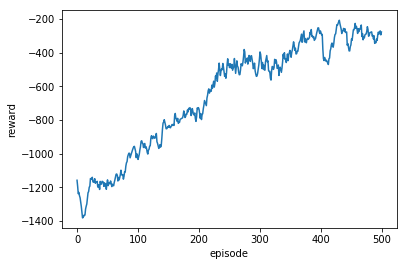

Parameter server: ended...
All done.
--- 602.1372051239014 seconds ---


In [0]:
cluster = tf.train.ClusterSpec({
    "worker": ["localhost:3331",
               "localhost:3332",
               "localhost:3333",
               "localhost:3334"
              ],
    "ps": ["localhost:3330"]
})

def parameter_server():
    #tf.reset_default_graph()
    
    server = tf.train.Server(cluster,
                             job_name="ps",
                             task_index=0)
    sess = tf.Session(target=server.target)        
    
    with tf.device("/job:ps/task:0"):
        GLOBAL_PPO = PPO(net_scope, sess, env, global_PPO=None) # only need its params
        GLOBAL_EP = tf.Variable(0.0, name='GLOBAL_EP') # num of global episodes   
        # a queue of ep_r
        GLOBAL_RUNNING_R = tf.FIFOQueue(EP_MAX, tf.float32, shared_name="GLOBAL_RUNNING_R")        
    
    print("Parameter server: waiting for cluster connection...")
    sess.run(tf.report_uninitialized_variables())
    print("Parameter server: cluster ready!")
    
    print("Parameter server: initializing variables...")
    sess.run(tf.global_variables_initializer())
    print("Parameter server: variables initialized")
    
    while True:
        time.sleep(1.0)
        if sess.run(GLOBAL_RUNNING_R.size()) >= EP_MAX: # GLOBAL_EP starts from 0, hence +1 to max_global_episodes          
            time.sleep(10.0)
            GLOBAL_RUNNING_R_list = []
            ep_r_prev = 0.0
            for i in range(sess.run(GLOBAL_RUNNING_R.size())):
                ep_r = sess.run(GLOBAL_RUNNING_R.dequeue())                   
                if i==0:
                    GLOBAL_RUNNING_R_list.append(ep_r) # for display
                else:
                    GLOBAL_RUNNING_R_list.append(GLOBAL_RUNNING_R_list[-1]*0.9 + ep_r*0.1) # for display         
            break  
              
    # display
    plt.plot(np.arange(len(GLOBAL_RUNNING_R_list)), GLOBAL_RUNNING_R_list)
    plt.xlabel('episode')
    plt.ylabel('reward')
    plt.show()  

    #print("Parameter server: blocking...")
    #server.join() # currently blocks forever    
    print("Parameter server: ended...")

def worker(worker_n): 
    #tf.reset_default_graph()
    
    server = tf.train.Server(cluster,
                             job_name="worker",
                             task_index=worker_n)
    sess = tf.Session(target=server.target)  
  
    with tf.device("/job:ps/task:0"):
        GLOBAL_PPO = PPO(net_scope, sess, env, global_PPO=None) # only need its params
        GLOBAL_EP = tf.Variable(0.0, name='GLOBAL_EP') # num of global episodes
        # a queue of ep_r
        GLOBAL_RUNNING_R = tf.FIFOQueue(EP_MAX, tf.float32, shared_name="GLOBAL_RUNNING_R")   
    """
    with tf.device(tf.train.replica_device_setter(
                        worker_device='/job:worker/task:' + str(worker_n),
                        cluster=cluster)):
    """                        
    print("Worker %d: waiting for cluster connection..." % worker_n)
    sess.run(tf.report_uninitialized_variables())
    print("Worker %d: cluster ready!" % worker_n)
    
    #while sess.run(tf.report_uninitialized_variables()):
    while (sess.run(tf.report_uninitialized_variables())).any(): # ********** .any() .all() **********
        print("Worker %d: waiting for variable initialization..." % worker_n)
        time.sleep(1.0)
    print("Worker %d: variables initialized" % worker_n)
    
    w = Worker(str(worker_n), GLOBAL_PPO, GLOBAL_EP, GLOBAL_RUNNING_R, sess) 
    print("Worker %d: created" % worker_n)
    
    sess.run(tf.global_variables_initializer()) # got to initialize after Worker creation
    w.work()
    print("Worker %d: w.work()" % worker_n)
          
    #print("Worker %d: blocking..." % worker_n)
    server.join() # currently blocks forever
    print("Worker %d: ended..." % worker_n)
    
start_time = time.time()

ps_proc = Process(target=parameter_server, daemon=True)
w1_proc = Process(target=worker, args=(0, ), daemon=True)
w2_proc = Process(target=worker, args=(1, ), daemon=True)
w3_proc = Process(target=worker, args=(2, ), daemon=True)
w4_proc = Process(target=worker, args=(3, ), daemon=True)

ps_proc.start()
w1_proc.start()
w2_proc.start()
w3_proc.start()
w4_proc.start() 

# if not join, parent will terminate before children 
# & children will terminate as well cuz children are daemon
ps_proc.join() 
#w1_proc.join()
#w2_proc.join() 
#w3_proc.join() 
#w4_proc.join() 

for proc in [w1_proc, 
             w2_proc, 
             w3_proc, 
             w4_proc, 
             ps_proc]:
    proc.terminate() # only way to kill server is to kill it's process
        
print('All done.')     

print("--- %s seconds ---" % (time.time() - start_time))    